In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import h5py as h5
import hdf5plugin
from matplotlib.colors import LogNorm
import skbeam.core.correlation as corr
import scipy.ndimage as ndimage
import time

from lmfit.models import GaussianModel, ConstantModel

from importlib import reload
import lsco_ana as lsco
reload(lsco)
import xpcs_ana as xpcs
reload(xpcs)

<module 'xpcs_ana' from 'C:\\Users\\espov\\Documents\\Science_projects\\LSCO\\LSCO_DESY\\xpcs_ana.py'>

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

# Load data

Image number of interest: 50
Center of Mass of the image : 301, 300


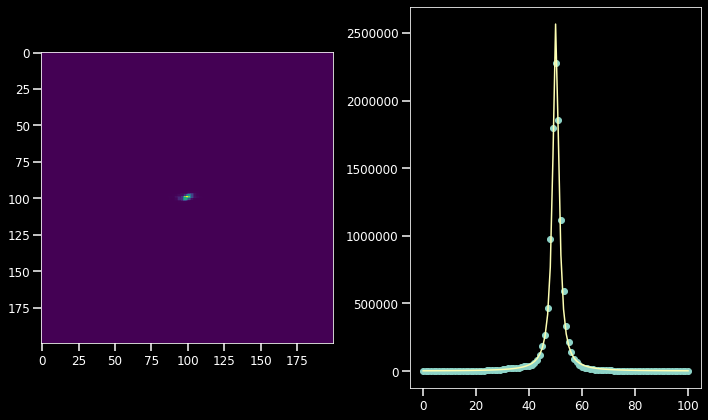

(1800, 600, 600)


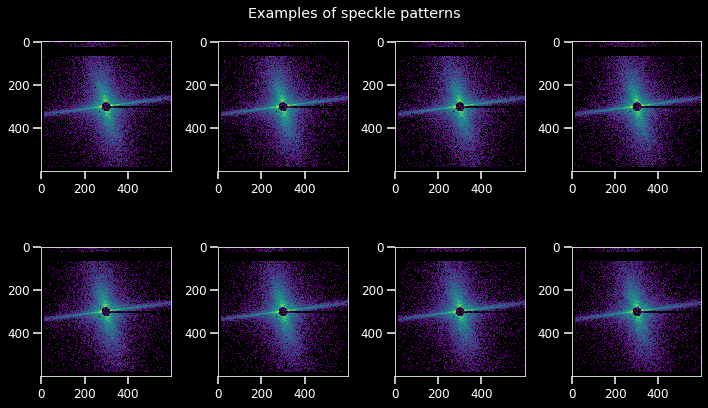

In [3]:
data_dir = Path(r'C:\Users\espov\Desktop\DESY')
r_th = 24
r_time = 25
drow1, drow2, dcol1, dcol2 = 300,300,300,300  # region of interest size

# Analyze th scan: find peak center
feiger, fmaster, fbatchinfo = lsco.get_file_name(r_th, data_dir)
feiger = h5.File(feiger, 'r')
fmaster = h5.File(fmaster, 'r')
eiger = np.asarray(feiger['entry']['data']['data'])
qoi,com = lsco.centering_ls(eiger, drow1, drow2, dcol1, dcol2)

# Analyze time series
feiger, fmaster, fbatchinfo = lsco.get_file_name(r_time, data_dir)
feiger = h5.File(feiger, 'r')
fmaster = h5.File(fmaster, 'r')
eiger = np.asarray(feiger['entry']['data']['data'][:,qoi[0]:qoi[1], qoi[2]:qoi[3]])
print(eiger.shape)
eiger[eiger>1e7] = 0
fig, axs = plt.subplots(nrows=2, ncols=4)
fig.suptitle('Examples of speckle patterns')
for ii, ax in enumerate(axs.ravel()):
    ax.imshow(eiger[100*ii], norm=LogNorm())
plt.tight_layout()
plt.show()

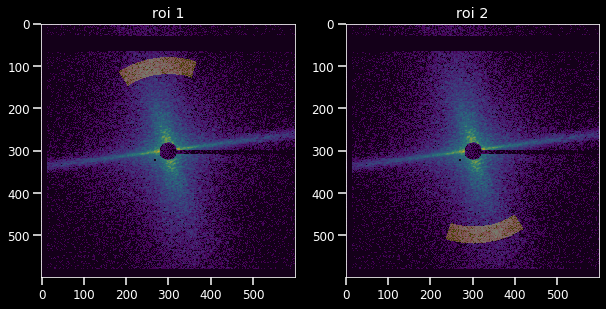

In [4]:
rad, phi = xpcs.polarCoord(eiger[0].shape, com)
r0, dr, phi0, dphi, tilt = 200., 20., 90., 25, 7.5
roi1 = lsco.roi_lsco(eiger[0], com, r0, dr, phi0, dphi, tilt)
r0, dr, phi0, dphi, tilt = 200., 20., -90., 25, 7.5
roi2 = lsco.roi_lsco(eiger[0], com, r0, dr, phi0, dphi, tilt)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(eiger[0], norm=LogNorm())
ax[0].imshow(roi1, alpha=0.3)
ax[0].set_title('roi 1')
ax[1].imshow(eiger[0], norm=LogNorm())
ax[1].imshow(roi2, alpha=0.3)
ax[1].set_title('roi 2')
plt.show()

# Non-uniform illumination correction

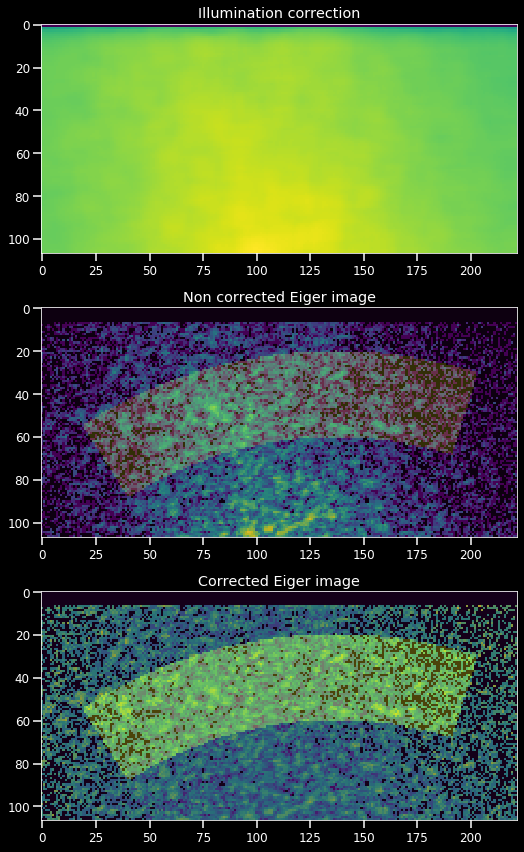

In [5]:
ksize = 10
eiger_corr, roi, bp = xpcs.correct_illumination(eiger, roi1, kernel_size=ksize)

fig, ax = plt.subplots(nrows=3, figsize=(8,12))
ax[0].set_title('Illumination correction')
ax[0].imshow(bp, norm=LogNorm())
# ax[0].imshow(roi, alpha=0.2)

ax[1].set_title('Non corrected Eiger image')
ax[1].imshow(xpcs.box_to_roi_extend(eiger[1000],roi1, extend=2*ksize)[0], norm=LogNorm())
ax[1].imshow(roi, alpha=0.2)

ax[2].set_title('Corrected Eiger image')
ax[2].imshow(eiger_corr[1000], norm=LogNorm())
ax[2].imshow(roi, alpha=0.3)

plt.tight_layout()
plt.show()

## Check spatial autocorrelation after correction

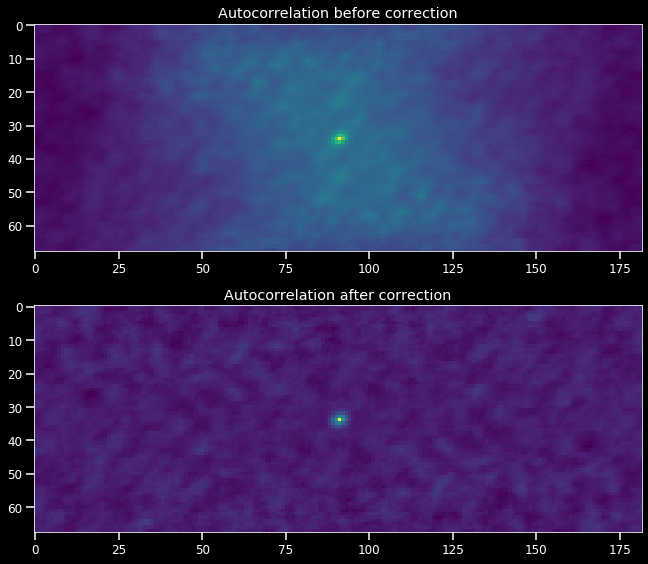

In [6]:
img = xpcs.box_to_roi_extend(eiger[3],roi1, extend=2*ksize)[0]
A = xpcs.spatial_correlation_fourier(img, mask=roi)

fig, ax = plt.subplots(nrows=2, figsize=(10,8))
ax[0].imshow(A)
ax[0].set_title("Autocorrelation before correction")

img = eiger_corr[3]
A = xpcs.spatial_correlation_fourier(img, mask=roi)

ax[1].imshow(A)
ax[1].set_title("Autocorrelation after correction")
plt.tight_layout()
plt.show()

[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 67
    # variables        = 4
    chi-square         = 0.02954867
    reduced chi-square = 4.6903e-04
    Akaike info crit   = -509.669411
    Bayesian info crit = -500.850640
[[Variables]]
    amplitude:  1.67981356 +/- 0.06658018 (3.96%) (init = 3)
    center:     34.0000000 +/- 0.05628395 (0.17%) (init = 34)
    sigma:      1.39048668 +/- 0.07071714 (5.09%) (init = 2)
    c:          0.99896986 +/- 0.00278693 (0.28%) (init = 1)
    fwhm:       3.27434584 +/- 0.16652613 (5.09%) == '2.3548200*sigma'
    height:     0.48195261 +/- 0.02701587 (5.61%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, c)     = -0.287
    C(amplitude, sigma) =  0.252
    C(sigma, c)         = -0.195


[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    #

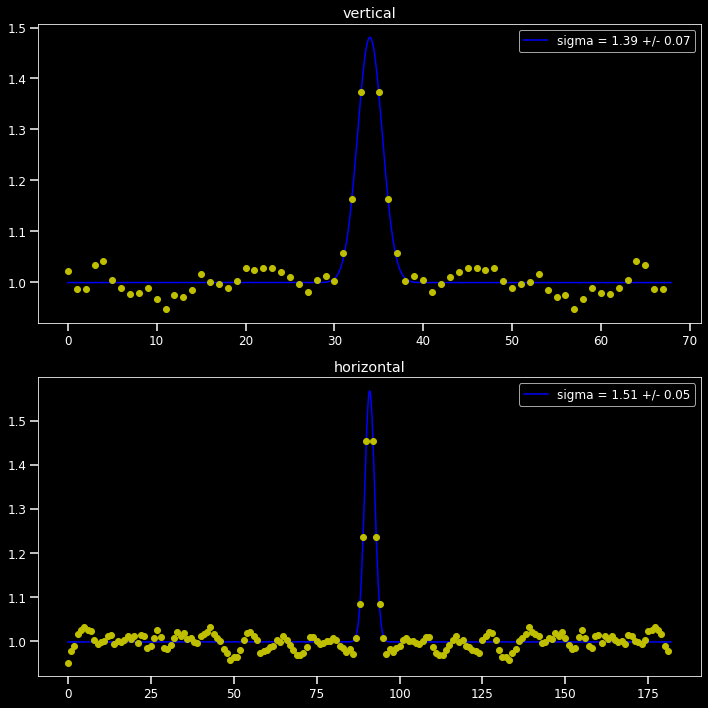

In [7]:
A2 = xpcs.remove_central_corr(A)
xx = A2.shape[0]//2
yy = A2.shape[1]//2
horiz = A2[xx,:]
vert = A2[:,yy]
data = [vert, horiz]
titles = ['vertical', 'horizontal']

fig, ax = plt.subplots(nrows=2, figsize=(10,10))
for ii, dat in enumerate(data):
    center = np.where(np.isnan(dat))[0][0]
    
    gmodel = GaussianModel(nan_policy='omit')+ConstantModel(nan_policy='omit')
    params = gmodel.make_params()
    params['amplitude'].value = 3
    params['sigma'].value = 2
    params['center'].value = center
    params['c'].value = 1
    
#     dat = dat[center-n:center+n]
    x = np.arange(dat.shape[0])
    res = gmodel.fit(dat, params, x=x)
    
    xfit = np.arange(0,2*center,0.1)
    ax[ii].plot(xfit, res.eval(x=xfit), color='b', 
                label='sigma = {:.2f} +/- {:.2f}'.format(res.params['sigma'].value, res.params['sigma'].stderr))
    ax[ii].plot(dat, 'o', color='y')
    ax[ii].legend(loc='upper right')
    ax[ii].set_title(titles[ii])
    print(res.fit_report())
    print('\n')
    
plt.tight_layout()
plt.show()

## Check time autocorrelation after correction

In [8]:
num_levels = 1
num_bufs = eiger_corr.shape[0]
num_frames = eiger_corr.shape[0]

tic = time.time()
twoTime_roi = corr.two_time_corr(roi, eiger_corr, num_frames, num_bufs, num_levels=1)
print(np.round(time.time()-tic))

172.0


Text(0.5, 1.0, 'Two time correlation run 25, roi 1')

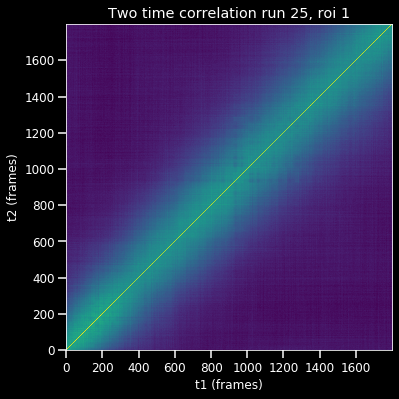

In [9]:
fig, ax = plt.subplots()
ax.imshow(twoTime_roi.g2[0], origin="lower")
ax.set_xlabel("t1 (frames)")
ax.set_ylabel("t2 (frames)")
ax.set_title("Two time correlation run 25, roi 1")

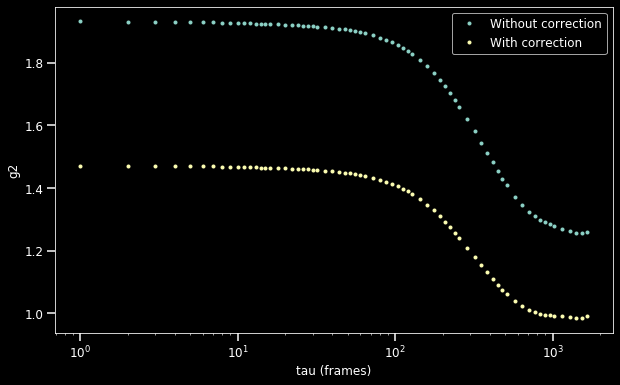

In [10]:
num_levels = 10
num_bufs = 16

fig, ax = plt.subplots()
g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, roi1, (im for im in eiger))
ax.plot(lag_steps[1:], g2[1:], 'o', markersize=3, label='Without correction')
g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, roi, (im for im in eiger_corr))
ax.plot(lag_steps[1:], g2[1:], 'o', markersize=3, label='With correction')
ax.set_xscale('log')
ax.set_xlabel('tau (frames)')
ax.set_ylabel('g2')
ax.legend()
plt.show()

# Do we have heterogeneous dynamics?

In [11]:
#test